In [2]:
import flopy
import os
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import datetime
import shutil
import time

########## INPUT #############
it = int(sys.argv[1])-1
f_varlist = Path(sys.argv[2])
job_id = sys.argv[3]

# it=0
# f_varlist = Path('../data/PriorModel/varlist.pkl')
# job_id='test'
print(it,f_varlist,job_id)

########## INPUT #############


if sys.platform.lower()=='linux':
    datadir = Path('/scratch/users/ianpg/SWIlarge/data')
    workdir = Path('/scratch/users/ianpg/SWIlarge/work')
    MPSdir = datadir.joinpath('lith/sgems/MPS')
    lithdir = datadir.joinpath('lith/sgems/')
    GISdir = datadir.joinpath('GIS')
    priordir = datadir.joinpath('PriorModel')
    modeldir = datadir.joinpath('NM_model')
elif sys.platform.lower()=='darwin':
    datadir = Path('../data')
    workdir = Path('../work')
    MPSdir = Path('/Users/ianpg/Dropbox/temp_convenience/SWIlarge/data/lith/sgems/MPS')
    GISdir = datadir.joinpath('GIS')
    lithdir = datadir.joinpath('lith/sgems/')
    priordir = datadir.joinpath('PriorModel')
    modeldir = datadir.joinpath('NM_model')

nmgwmdir_empty = datadir.joinpath('nmgwmdir_empty') #<-- removed everything but DIS
nmgwmdir_cal = datadir.joinpath('Calibrated_small') #<-- removed RCH, WEL, GLO, LST from the NAM file to load much faster
figdir = workdir.joinpath('figs')
outputdir = workdir.joinpath('output')

import config
import utils



#%% Useful functions
def load_obj(dirname,name):
    import pickle
    with open(Path(dirname).joinpath(name + '.pkl').as_posix(), 'rb') as f:
        return pickle.load(f)

def save_obj(dirname,obj,name):
    import pickle
    with open(Path(dirname).joinpath(name + '.pkl').as_posix(), 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def make_timestamp(YMD=True,HM=True):
    import datetime
    if YMD:
        ymd = '%Y%m%d'
    else:
        ymd = ''
    if HM:
        hm = '%H%M'
    else:
        hm = ''
    if YMD and HM:
        sep = '_'
    else:
        sep = ''
    return datetime.datetime.now().strftime('{}{}{}'.format(ymd,sep,hm))



if len(f_varlist.name.split('.'))>1:
    nam = f_varlist.name.split('.')[0]
else:
    nam = f_varlist.name
varlist = load_obj(f_varlist.parent,nam)
ts = make_timestamp()




0 ../data/PriorModel/varlist.pkl test
system: linux
copying files...
loading model...
unpacking and setting new vars...
creating new package objs...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mflpf.ModflowLpf'> <class 'flopy.modflow.mflpf.ModflowLpf'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.mt3d.mtbtn.Mt3dBtn'> <class 'flopy.mt3d.mtbtn.Mt3dBtn'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.mt3d.mtdsp.Mt3dDsp'> <class 'flopy.mt3d.mtdsp.Mt3dDsp'>
replacing existing Package...


In [94]:

print('copying files...')
model_ws = workdir.joinpath('SV_{}'.format(it))

print('loading model...')
##Loading
modelname = 'SV'
m= flopy.seawat.Seawat.load(modelname + '.nam',exe_name=config.swexe, model_ws=model_ws.as_posix())
rows = np.load(model_ws.joinpath('rows.npy'))
starttime = np.load(model_ws.joinpath('starttime.npy'))
layer_mapping_ind_full = np.load(GISdir.joinpath('layer_mapping_ind_full.npy'))                                 
layer_mapping_ind = layer_mapping_ind_full[:,rows,:]
# m = flopy.seawat.Seawat(modelname, exe_name=config.swexe, model_ws=model_ws.as_posix(),verbose=verbose)
thinmsk_in_aqt = np.load(model_ws.joinpath('thinmsk_in_aqt.npy'))
wellmsk_in_aqt = np.load(model_ws.joinpath('wellmsk_in_aqt.npy'))


print('unpacking and setting new vars...')
##Unpack vars
thinning =varlist['thinning'][it] #done
n_conduits = int(varlist['n_conduits'][it])

por_sand = varlist['por_sand'][it] #done
por_clay = varlist['por_clay'][it] #done
aL = varlist['aL'][it] #done
kvh = varlist['kvh'][it] #done
kh_sand_180 = varlist['kh_sand_180'][it] #done
kh_clay_180 = varlist['kh_clay_180'][it] #done
kh_sand_400 = varlist['kh_sand_400'][it] #done
kh_clay_400 = varlist['kh_clay_400'][it] #done
kh_lay1     = varlist['kh_lay1'][it] #done 

x_cond =  np.random.randint(150,m.ncol-5,size=n_conduits)
y_cond =np.random.randint(rows[0],rows[-1],size=n_conduits)

msh=  np.array([np.meshgrid(np.arange(x-5,x+5),np.arange(y-5,y+5)) for x,y in zip(x_cond,y_cond)])
x_cond=np.ravel(msh[:,0,:,:])
y_cond=np.ravel(msh[:,1,:,:])

extra_conds = np.zeros_like(thinmsk_in_aqt)
extra_conds[:,y_cond,x_cond] = True
extra_conds = np.logical_and(extra_conds,layer_mapping_ind_full==4)


# thinning_msk = thinmsk_in_aqt.copy()
thinning_msk = np.logical_or(thinmsk_in_aqt,extra_conds)
thin =np.round(thinning/25,2)*25
thck = thinmsk_in_aqt.sum(axis=0)
thck_new = np.round((1-thin)*thck,0).astype(np.int)

for lay in range(m.nlay):
    ij = np.argwhere(thinmsk_in_aqt[lay,:,:])
    if len(ij)>0:
        for val in ij:
            thck_val = thinning_msk[:,val[0],val[1]].sum()
            if thck_new[val[0],val[1]]==0:
#                 print('zero thickness now...')
                thinning_msk[:,val[0],val[1]]=False
            else:
#                 print('thinning now...')
                thinning_msk[lay:lay+thck_new[val[0],val[1]],val[0],val[1]]=True
                thinning_msk[:lay,val[0],val[1]]=False
                thinning_msk[lay+thck_new[val[0],val[1]]:,val[0],val[1]]=False        
            

            
hk_aquitard = min(kh_clay_180,kh_clay_400)
hk = np.zeros_like(layer_mapping_ind_full,dtype=np.float)
lith_180 = np.load(lithdir.joinpath('snesim','mps180_{}.npy'.format(it))).astype(np.float)
lith_400 = np.load(lithdir.joinpath('sisim','sisim400_{}.npy'.format(it))).astype(np.float)



lith_180[lith_180==1.] = kh_sand_180
lith_180[lith_180==0.] = kh_clay_180
lith_400[lith_400==1.] = kh_sand_400
lith_400[lith_400==0.] = kh_clay_400


hk[np.where(layer_mapping_ind_full==0)] = 5000
hk[np.where(layer_mapping_ind_full==1)] = kh_lay1
hk[np.where(layer_mapping_ind_full==2)] = hk_aquitard
hk[np.where(layer_mapping_ind_full==3)] = lith_180[np.where(layer_mapping_ind_full==3)]
hk[np.where(layer_mapping_ind_full==4)] = hk_aquitard
hk[np.where(layer_mapping_ind_full==5)] = lith_400[np.where(layer_mapping_ind_full==5)]
hk[np.where(layer_mapping_ind_full>5)] = 1.

hk[np.where(wellmsk_in_aqt)]=kh_sand_180
hk[np.where(thinmsk_in_aqt)]=kh_sand_180





prsity = np.zeros_like(layer_mapping_ind_full,dtype=np.float)
prsity[np.isin(hk,(kh_lay1,kh_sand_180,kh_sand_400))]=por_sand
prsity[np.where(prsity==0.)]=por_clay


hk = hk[:,rows,:]
prsity = prsity[:,rows,:]


copying files...
loading model...
unpacking and setting new vars...


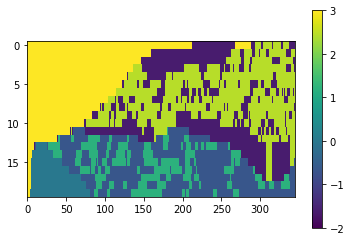

In [96]:
plt.figure()
plt.imshow(np.log10(hk)[:,1,:],vmin=-2,vmax=3,interpolation='nearest')
plt.gca().set_aspect(10)
plt.colorbar()

In [97]:

print('creating new package objs...')

lpf = flopy.modflow.ModflowLpf(m, hk=hk, vka=kvh, ipakcb=m.lpf.ipakcb,laytyp=0,laywet=0,
                              ss=m.lpf.ss.array,sy=m.lpf.sy.array)

try:
    sconc= m.btn.sconc.array
except:
    sconc= m.btn.sconc[0].array
btn = flopy.mt3d.Mt3dBtn(m,
                         laycon=m.btn.laycon.array, htop=m.btn.htop.array,
                         dz=m.dis.thickness.get_value(), prsity=prsity, icbund=m.btn.icbund.array,
                         sconc=sconc, nprs=1,timprs=m.btn.timprs)

dsp = flopy.mt3d.Mt3dDsp(m, al=aL,dmcoef=2.0e-9)

creating new package objs...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mflpf.ModflowLpf'> <class 'flopy.modflow.mflpf.ModflowLpf'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.mt3d.mtbtn.Mt3dBtn'> <class 'flopy.mt3d.mtbtn.Mt3dBtn'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.mt3d.mtdsp.Mt3dDsp'> <class 'flopy.mt3d.mtdsp.Mt3dDsp'>
replacing existing Package...


In [101]:

writeyn= True
runyn = True
#Write input
if writeyn:
    print('writing...')
    m.write_input()
    
    
# Try to delete the output files, to prevent accidental use of older files
f_delete = [os.path.join(m.model_ws,'MT3D.CNF'),
            os.path.join(m.model_ws,'MT3D001.MAS'),
            os.path.join(m.model_ws, 'MT3D001.UCN'),
            os.path.join(m.model_ws, modelname + '.hds'),
            os.path.join(m.model_ws, modelname + '.cbc')]

for f in f_delete:
    try:
        os.remove(f)
    except:
        pass

#%%

if runyn:
    print('running...')
    v = m.run_model(silent=False, report=True)
    for idx in range(-3, 0):
        print(v[1][idx])
else:
    print('Not running model!')

exportdir = outputdir.joinpath('SV')
if not exportdir.exists():
    exportdir.mkdir(parents=True)

date_per = starttime + np.cumsum(m.dis.perlen.array)/365
survey_date = 2017.25
survey_kper = np.argmin(np.abs(date_per-survey_date))

fname = os.path.join(m.model_ws, 'MT3D001.UCN')
totim = flopy.utils.binaryfile.UcnFile(fname).get_times()[-1]
try:
    conc_fname = 'conc{}_{}_totim{}_{}.UCN'.format(
        it, ts, str(int(totim)),job_id)
except:
    conc_fname = 'conc{}_{}_totim{}.UCN'.format(
        it, ts, str(int(totim)))

utils.copy_rename(fname,
                 exportdir.joinpath(conc_fname))
conc = flopy.utils.binaryfile.UcnFile(fname).get_data(kstpkper=(0,survey_kper))
np.save(exportdir.joinpath(conc_fname[:-4] + '.npy'),conc)


end_date = 2030.9
end_kper = np.argmin(np.abs(date_per-end_date))

conc = flopy.utils.binaryfile.UcnFile(fname).get_data(kstpkper=(0,end_kper))
np.save(exportdir.joinpath(conc_fname[:-4] + 'end.npy'),conc)

writing...
running...
FloPy is using the following  executable to run the model: /home/groups/rknight/swtv4

                                  SEAWAT Version 4
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 4.00.05 10/19/2012                      

Incorporated MODFLOW Version: 1.18.01 06/20/2008                      
Incorporated MT3DMS  Version: 5.20    10/30/2006                      


 This program is public domain and is released on the
 condition that neither the U.S. Geological Survey nor
 the United States Government may be held liable for any
 damages resulting from their authorized or unauthorized
 use.


 Using NAME file: SV.nam                                                                                                                                                                                                  
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2020/07/10 11:13:29


 STRESS PERIOD NO.  

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1732E-01  [K,I,J]   11    4  166
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1674E-03  [K,I,J]    2   26  188
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4839E-05  [K,I,J]    2   26  188
 Transport Step:   25   Step Size:   2.967     Total Elapsed Time:   58.071    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1679E-01  [K,I,J]   11    4  166
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1446E-03  [K,I,J]    2   26  188
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4438E-05  [K,I,J]    2   26  188
 Transport Step:   26   Step Size:   2.967     Total Elapsed Time:   61.038    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1622E-01  [K,I,J]   11    4  166
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1248E-03  [K,I,J]    2   26  188
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4060E-05  [K,I,J]    2   26  188
 Transport Step:   27   Step Size:   2.967     Total Elapsed Time:   64.005    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1118E-01  [K,I,J]    2   26  161
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4298E-04  [K,I,J]    3   26  160
 Transport Step:   58   Step Size:   2.967     Total Elapsed Time:   155.98    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1105E-01  [K,I,J]    2   26  161
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4145E-04  [K,I,J]    3   26  160
 Transport Step:   59   Step Size:   2.967     Total Elapsed Time:   158.95    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1090E-01  [K,I,J]    2   26  161
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3993E-04  [K,I,J]    3   26  160
 Transport Step:   60   Step Size:   2.967     Total Elapsed Time:   161.91    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1076E-01  [K,I,J]    2   26  161
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3841E-04  [K,I,J]    3   26  160
 Transport Step:   61   Step Size:   2.967     Total Elapsed Time:   164.88    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9451E-02  [K,I,J]    2   27  175
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4574E-04  [K,I,J]    2   26  188
 Transport Step:   25   Step Size:   2.968     Total Elapsed Time:   256.70    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9389E-02  [K,I,J]    2   27  175
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4592E-04  [K,I,J]    2   26  188
 Transport Step:   26   Step Size:   2.968     Total Elapsed Time:   259.67    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9340E-02  [K,I,J]    2   27  176
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4604E-04  [K,I,J]    2   26  188
 Transport Step:   27   Step Size:   2.968     Total Elapsed Time:   262.64    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9287E-02  [K,I,J]    2   27  176
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4610E-04  [K,I,J]    2   26  188
 Transport Step:   28   Step Size:   2.968     Total Elapsed Time:   265.61    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7465E-02  [K,I,J]    2   27  182
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2089E-04  [K,I,J]    3   25  188
 Transport Step:   60   Step Size:   2.968     Total Elapsed Time:   360.59    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7390E-02  [K,I,J]    2   27  182
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2039E-04  [K,I,J]    3   25  188
 Transport Step:   61   Step Size:   2.968     Total Elapsed Time:   363.55    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7313E-02  [K,I,J]    2   27  182
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1989E-04  [K,I,J]    3   25  188
 Transport Step:   62   Step Size:   1.445     Total Elapsed Time:   365.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3541E-02  [K,I,J]    2   27  182
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2724E-05  [K,I,J]    3   25  188
 Transport Step:   63   Step Size:  5.6843E-14 Total Elapsed Time:   365.00    
 Outer Iter.  1  Inner Iter.  1:  Max. D

KeyboardInterrupt: 